In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anime-recommendations-database/rating.csv
/kaggle/input/anime-recommendations-database/anime.csv


# **Goal: Determine which anime genre and anime type has highest rating.**

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.ensemble import RandomForestRegressor

In [3]:
anime = pd.read_csv("../input/anime-recommendations-database/anime.csv")
rating = pd.read_csv("../input/anime-recommendations-database/rating.csv")

# **Data Preprocessing: anime Data Set**

In [4]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [6]:
has_null = {}
for col in anime.columns:
    print("Column \"{}\" has {} null values out of {} values. Percentage if null is {}%."
          .format(col, anime[col].isna().sum(), anime[col].size, round(anime[col].isna().sum()/anime[col].size*100,3) ) )
    if anime[col].isna().sum()>0:
        has_null[col] = anime[col].isna().sum()

Column "anime_id" has 0 null values out of 12294 values. Percentage if null is 0.0%.
Column "name" has 0 null values out of 12294 values. Percentage if null is 0.0%.
Column "genre" has 62 null values out of 12294 values. Percentage if null is 0.504%.
Column "type" has 25 null values out of 12294 values. Percentage if null is 0.203%.
Column "episodes" has 0 null values out of 12294 values. Percentage if null is 0.0%.
Column "rating" has 230 null values out of 12294 values. Percentage if null is 1.871%.
Column "members" has 0 null values out of 12294 values. Percentage if null is 0.0%.


In [7]:
anime_categorical = anime.select_dtypes(include=[object])
anime_numerical = anime.select_dtypes(include = [np.number])

In [8]:
anime_categorical.describe()

,name,genre,type,episodes
count,12294,12232,12269,12294
unique,12292,3264,6,187
top,Shi Wan Ge Leng Xiaohua,Hentai,TV,1
freq,2,823,3787,5677


In [9]:
anime_numerical.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [10]:
anime.duplicated().unique()
# no duplicate row

array([False])

In [11]:
anime = anime.sort_values(by="anime_id")
anime.set_index("anime_id")
# anime_id isn't numerically increase consistently but that's fine 

,name,genre,type,episodes,rating,members
anime_id,,,,,,
1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,8.40,137636
6,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069
7,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna...",TV,26,7.36,64905
8,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural",TV,52,7.06,9848
...,...,...,...,...,...,...
34514,Pokemon Generations,"Action, Adventure, Fantasy, Game, Kids",ONA,18,7.21,295
34519,Mobile Suit Gakuen: G-Reco Koushien,Comedy,Special,9,5.67,94
34522,"Wake Up, Girls! Shin Shou","Drama, Music",TV,Unknown,NaN,381


<AxesSubplot:>

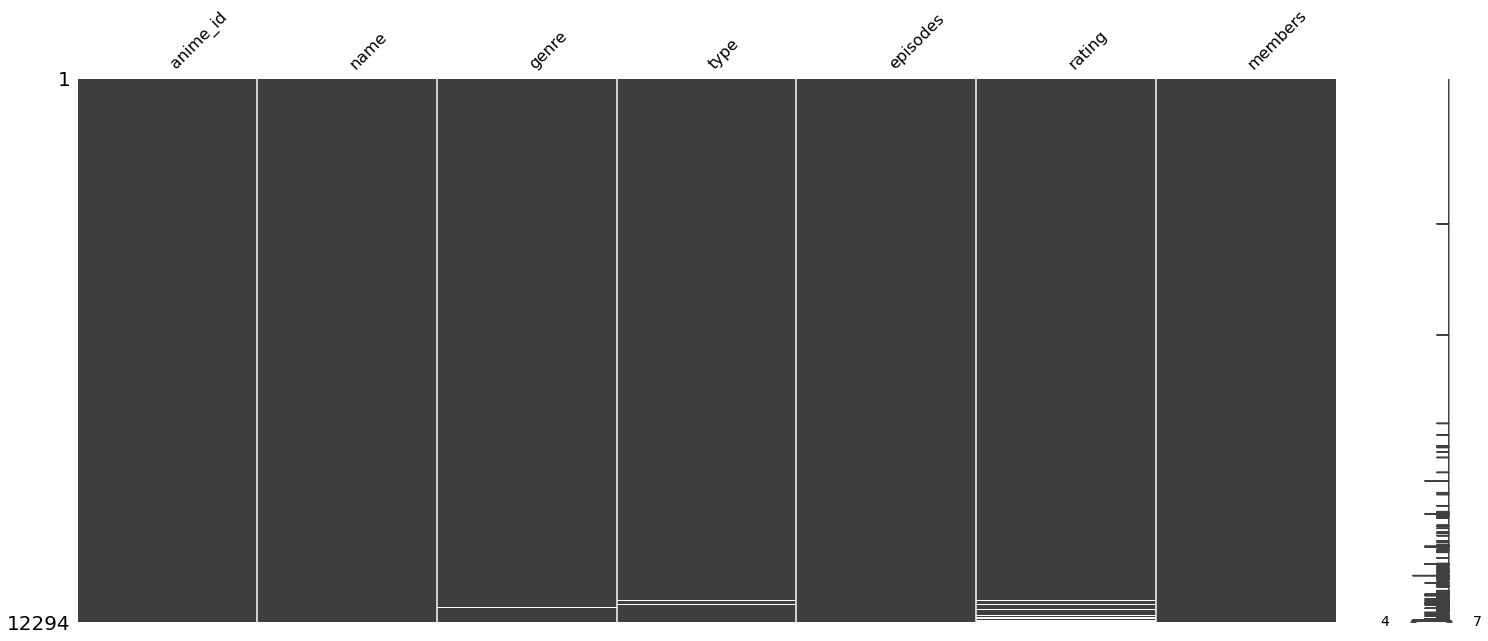

In [12]:
msno.matrix(anime)

<AxesSubplot:>

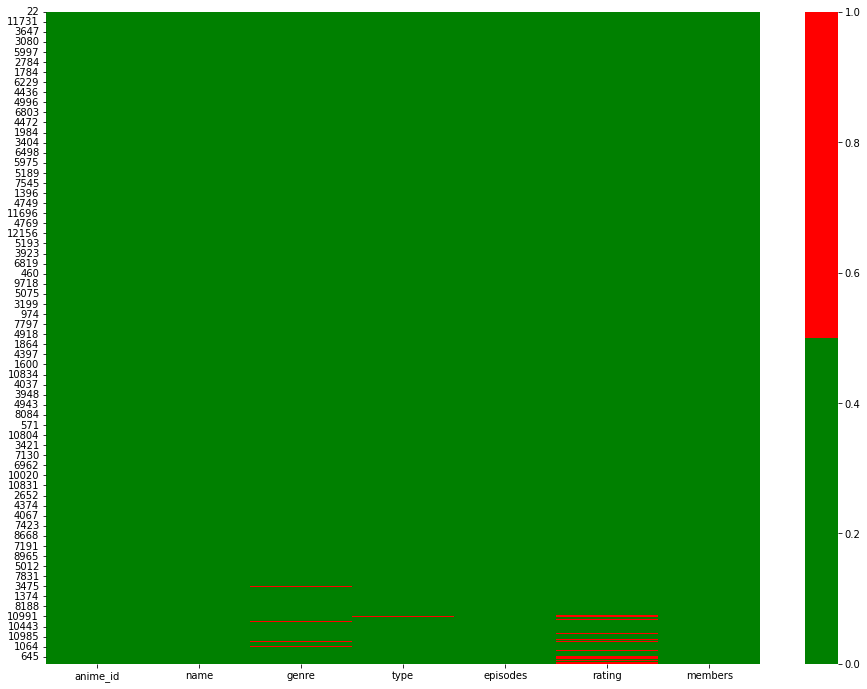

In [13]:
plt.figure(figsize=(16,12))
sns.heatmap(anime.isna(), cmap=sns.color_palette(["green","red"]) )

/opt/conda/lib/python3.7/site-packages/missingno/missingno.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([int(n*len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<AxesSubplot:>

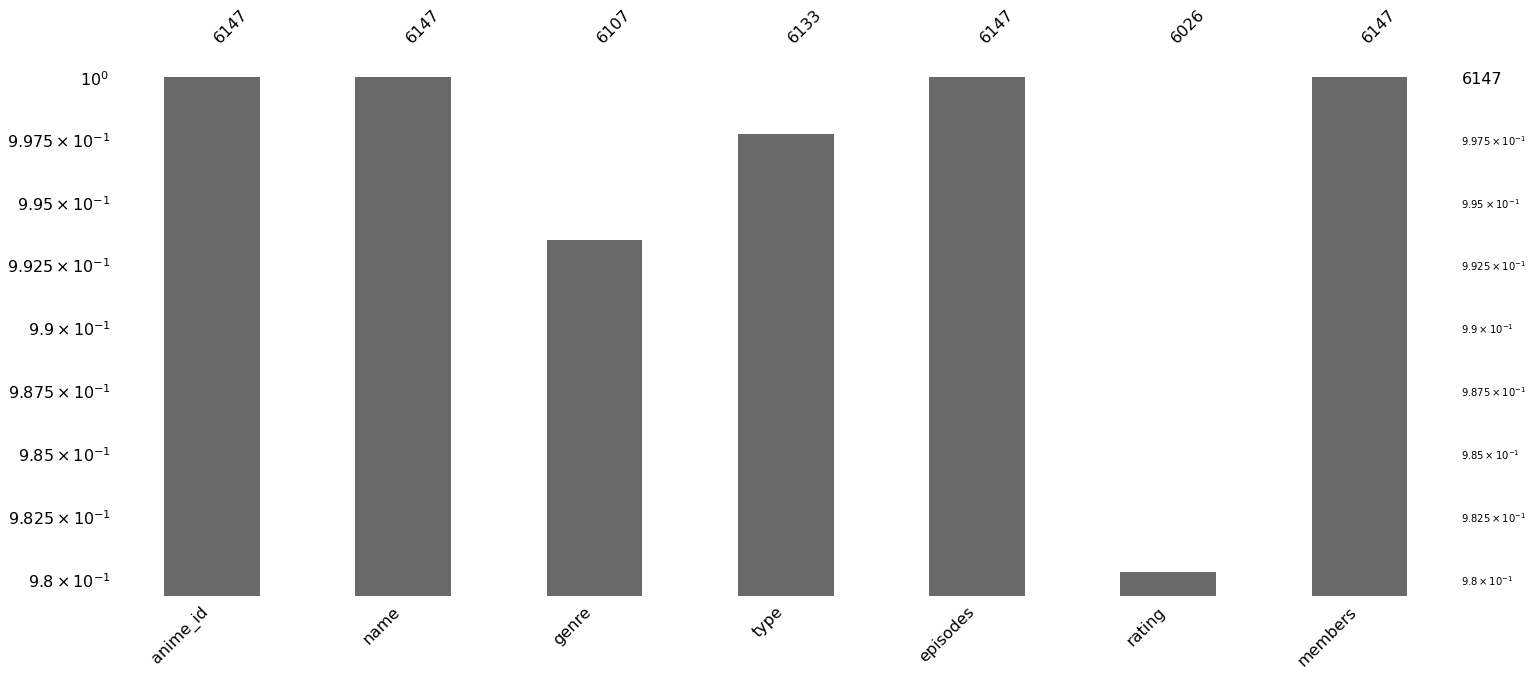

In [14]:
msno.bar(anime.sample(int(anime.shape[0]*0.5)) , log=True )
#half of data set

<AxesSubplot:>

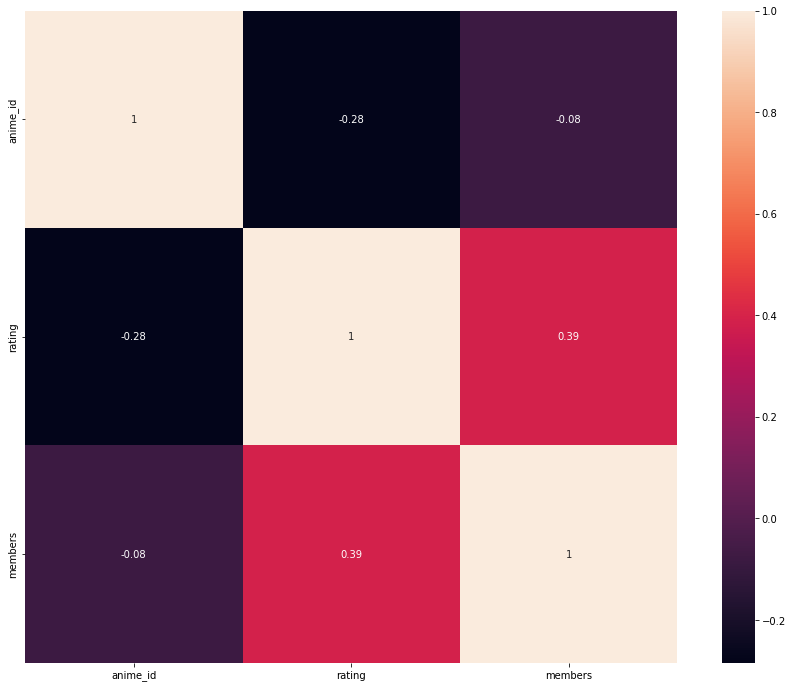

In [15]:
# correlation of numerical features
plt.figure( figsize=(16,12))
sns.heatmap( anime_numerical.corr(), square= True, robust=True, annot=True)

In [16]:
def update_null_dict(str):
    has_null = dict( [ (col, anime[col].isna().sum()) for col in anime.columns if anime[col].isna().sum()>0 ] )
    print("Updated null_list after cleaning \"{}\": {}".format(str,has_null))

#dealing with columns that have null values. Easy to do so since we only have 3 columns with null values 
print("Columns with null values and number of null values: {}".format(has_null) )

# I will just drop all rows with empty genre 
idx = anime[anime["genre"].isna()].index
anime = anime.drop(index=idx)
update_null_dict("genre")

Columns with null values and number of null values: {'genre': 62, 'type': 25, 'rating': 230}
Updated null_list after cleaning "genre": {'type': 22, 'rating': 215}


In [17]:
# cleaning rating
# cheacking whether there's null value been replaced by -1 (as in rating data set) or outlier rating ( x >10 or x<0 )

been_replaced = anime[anime["rating"] == -1]
print(been_replaced)
# no. 

has_outlier = anime[ (anime["rating"]>10) & (anime["rating"]<0) ]
print(has_outlier)
# no. every anime's rating is <=10 and >=0

# fill the null values with mean
anime["rating"] = anime["rating"].fillna(anime["rating"].mean())

update_null_dict("rating")


Empty DataFrame
Columns: [anime_id, name, genre, type, episodes, rating, members]
Index: []
Empty DataFrame
Columns: [anime_id, name, genre, type, episodes, rating, members]
Index: []
Updated null_list after cleaning "rating": {'type': 22}


In [18]:
#pre checking before dealing with null values in type

#print unique values of type
print("Anime Type: {}".format(anime["type"].unique()))

#print unique values of episodes
print("All possible episodes in this data set: {}\n\n".format(anime["episodes"].unique()))

# is there any anime which has episode of 1 (which indicates it's a movie) but has unknown anime type?
print( anime [ (anime["episodes"]==1) & (anime["type"].isna())] )
#nope


# if an anime's episodes is unknown, then fill it with the most frequent episodes of that anime's type (noted that "episodes" is categorical thus I use "top" instead "mean")
# e.g., an anime of type "TV" has unknown "epiodes", i will fill this anime's "episodes" with the "TV" 's top (which is 12 in this case)

def getFreq(Thetype):
    return anime.loc[anime["type"]==Thetype]["episodes"].describe().top

#identify each anime type's most common episodes length
for animeType in anime["type"].unique():
        print("Anime of type {} has average of {} episodes.".format(animeType, getFreq(animeType)) )
        
# dealing with "Unknown" in "episodes"
for animeType in anime["type"].unique():
            anime.loc[ ((anime["episodes"]=='Unknown') & (anime["type"]==animeType)) , "episodes"] = getFreq(animeType)
    
print( (anime["episodes"]=='Unknown').unique()) #"Unknown" still existed in null values of "type", but at least "Unknown" in non-null "type" is clear

Anime Type: ['TV' 'Movie' 'OVA' 'Special' 'ONA' 'Music' nan]
All possible episodes in this data set: ['26' '1' '52' '145' '24' '74' '220' 'Unknown' '178' '12' '22' '69' '25'
 '4' '94' '5' '3' '13' '23' '43' '6' '50' '47' '51' '49' '39' '8' '7' '75'
 '62' '14' '44' '45' '64' '101' '27' '161' '2' '153' '70' '78' '42' '11'
 '167' '150' '366' '9' '16' '38' '48' '10' '76' '40' '20' '37' '41' '112'
 '224' '180' '296' '358' '63' '276' '46' '54' '15' '21' '35' '124' '86'
 '102' '36' '67' '291' '110' '29' '55' '201' '142' '109' '34' '136' '32'
 '73' '114' '19' '195' '58' '155' '96' '103' '113' '104' '192' '191' '203'
 '56' '80' '172' '65' '117' '28' '61' '30' '148' '128' '100' '17' '243'
 '92' '98' '105' '79' '31' '1787' '53' '33' '130' '18' '97' '193' '115'
 '170' '66' '330' '108' '68' '119' '95' '137' '60' '77' '72' '127' '99'
 '373' '300' '163' '91' '88' '154' '141' '156' '694' '87' '225' '164' '59'
 '182' '305' '365' '1471' '331' '175' '143' '200' '510' '151' '1428' '84'
 '726' '140' '83' '

In [19]:
#dealing with null values in "type"

top_type = anime["type"].describe().top

#fill with most frequent anime type, TV
anime["type"] = anime["type"].fillna(top_type)

#fill again the "Unknown" where their "type" were previously null
anime.loc[ ((anime["episodes"]=='Unknown') & (anime["type"]==top_type)) , "episodes"] = getFreq(top_type)

update_null_dict("type")

Updated null_list after cleaning "type": {}


In [20]:
# no more null "type"
print(print( (anime["type"]=='NaN').unique() ) )   #False only
print(anime[anime["type"].isna()])

[False]
None
Empty DataFrame
Columns: [anime_id, name, genre, type, episodes, rating, members]
Index: []


In [21]:
# no more "Unknown" "episodes"
print( (anime["episodes"]=='Unknown').unique()) # False only. 
print(anime[anime["episodes"]=="Unknown"])

[False]
Empty DataFrame
Columns: [anime_id, name, genre, type, episodes, rating, members]
Index: []


In [22]:
#group by genres
anime.tail()



,anime_id,name,genre,type,episodes,rating,members
2726,34514,Pokemon Generations,"Action, Adventure, Fantasy, Game, Kids",ONA,18,7.210000,295
9586,34519,Mobile Suit Gakuen: G-Reco Koushien,Comedy,Special,9,5.670000,94
11104,34522,"Wake Up, Girls! Shin Shou","Drama, Music",TV,12,6.478264,381
10952,34525,Centaur no Nayami,"Comedy, Fantasy, Slice of Life, Supernatural",TV,12,6.478264,108
10997,34527,Gou-chan. Moko to Chinjuu no Mori no Nakama-tachi,"Adventure, Kids",Movie,1,6.478264,5


In [23]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12232 entries, 22 to 10997
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12232 non-null  int64  
 1   name      12232 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12232 non-null  object 
 4   episodes  12232 non-null  object 
 5   rating    12232 non-null  float64
 6   members   12232 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 764.5+ KB


# **rating data set**

In [24]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [25]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [26]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [27]:
print(rating.duplicated().unique()) #False only. Indicates that no duplicate rows

[False  True]


In [28]:
#drop rows which has rating of -1 (indicates no rating)
rating = rating.drop(index= list(rating.loc[(rating["rating"]==-1)].index) )

In [29]:
# only left with rated anime
rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6337241 entries, 47 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 193.4 MB


In [30]:
rating

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [31]:
#group the data frame by anime_id
grouped_anime_id = rating.groupby(rating["anime_id"])

#I am going to store the mean rating in dictionary
mean_rating = {}

#get the mean rating for every anime
for id in list( grouped_anime_id.groups.keys() ):
        mean_rating[id] = grouped_anime_id.get_group(id).rating.mean() 
        
#convert mean_rating into data frame
mean_rating_df = pd.DataFrame(mean_rating.items(), columns=["anime_id", "mean_rating"])
mean_rating_df

,anime_id,mean_rating
0,1,8.869433
1,5,8.439724
2,6,8.419393
3,7,7.533426
4,8,7.198052
...,...,...
9922,34324,5.909091
9923,34325,7.333333
9924,34349,7.000000
9925,34367,5.250000


In [32]:
mean_rating_df

,anime_id,mean_rating
0,1,8.869433
1,5,8.439724
2,6,8.419393
3,7,7.533426
4,8,7.198052
...,...,...
9922,34324,5.909091
9923,34325,7.333333
9924,34349,7.000000
9925,34367,5.250000


In [33]:
#set index as anime_id to join with anime data set later
mean_rating_df.set_index("anime_id")

anime_merged = pd.merge(anime, mean_rating_df, on=["anime_id"])
anime_merged


,anime_id,name,genre,type,episodes,rating,members,mean_rating
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,8.869433
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,8.40,137636,8.439724
2,6,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069,8.419393
3,7,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna...",TV,26,7.36,64905,7.533426
4,8,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural",TV,52,7.06,9848,7.198052
...,...,...,...,...,...,...,...,...
9889,34324,Chiryokumaru,Action,ONA,1,5.40,817,5.909091
9890,34325,Pokemon XY&amp;Z Specials,"Action, Adventure, Comedy, Fantasy, Kids",Special,2,7.05,1454,7.333333
9891,34349,Diamond no Ace: Second Season OVA,"Comedy, School, Shounen, Sports",OVA,2,7.25,1885,7.000000
9892,34367,Long Riders Recap,"Comedy, Shounen, Slice of Life, Sports",Special,1,5.97,582,5.250000


<AxesSubplot:>

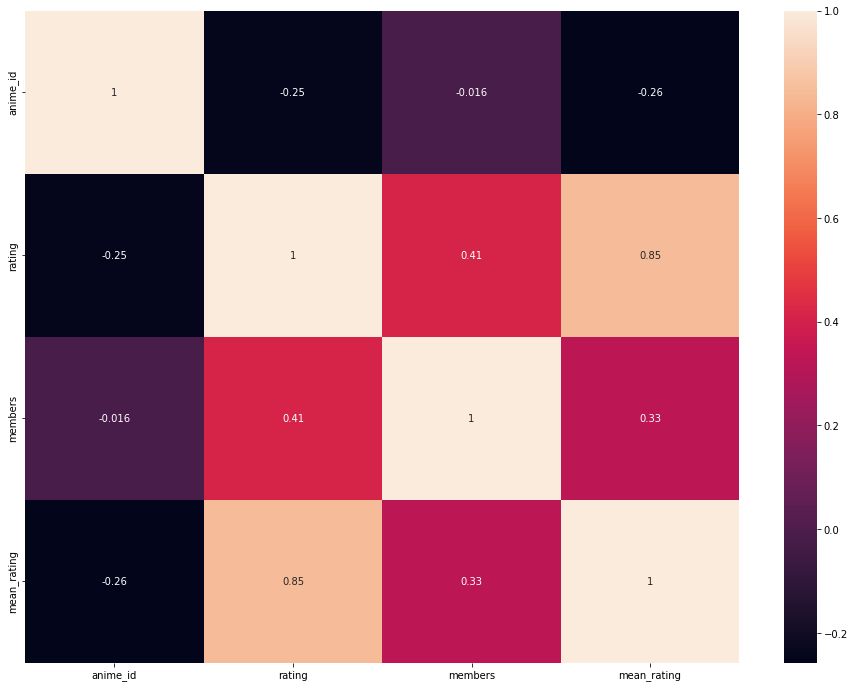

In [34]:
plt.figure(figsize=(16,12))
sns.heatmap(anime_merged.corr(), annot=True)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

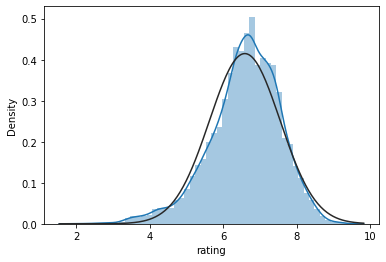

In [35]:
from scipy.stats import norm
sns.distplot(anime_merged["rating"], kde=True, fit=norm)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='skewness', ylabel='Density'>

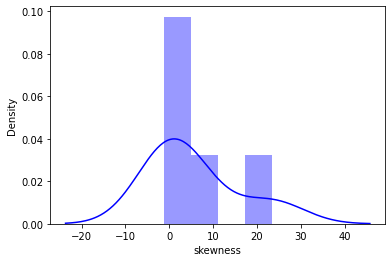

In [36]:
#skewness
sns.distplot(anime_merged.skew(), color="blue", axlabel="skewness")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Kurtosis', ylabel='Density'>

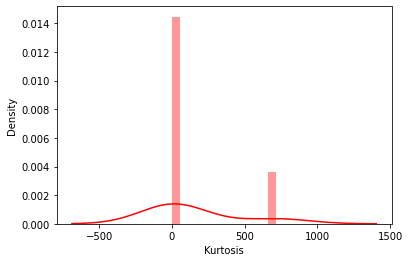

In [37]:
#kurtosis
sns.distplot(anime_merged.kurt(), color="red", axlabel="Kurtosis", norm_hist=False, kde=True, rug=False)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


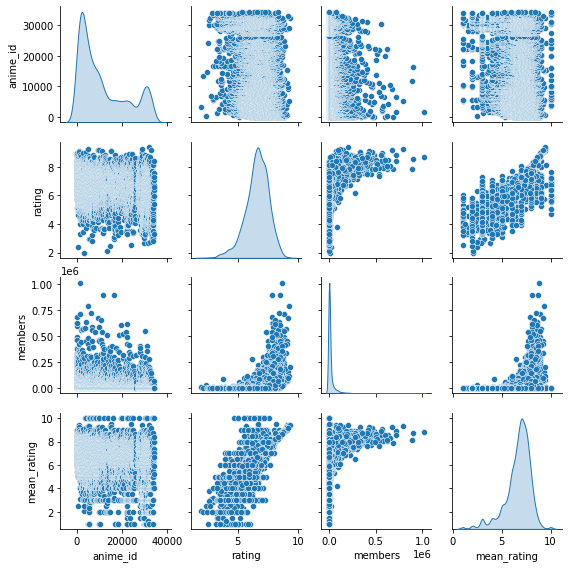

In [38]:
sns.pairplot(anime_merged, size=2, kind="scatter", diag_kind="kde")